# 实验三 三维重建

## 双目图像估计深度信息

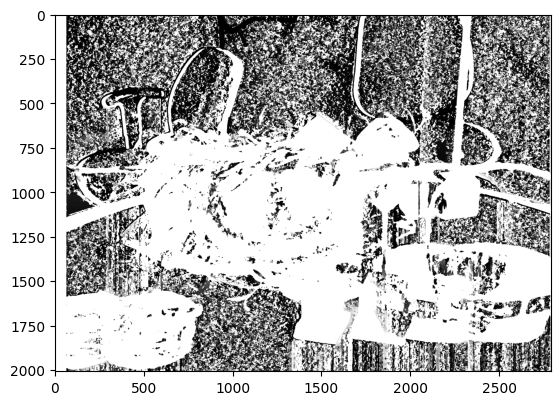

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取左右双目图像
left_image = cv2.imread('../my_data/im0.png')
right_image = cv2.imread('../my_data/im1.png')

# 创建立体视觉对象
# numDisparities:最大视差范围，blockSize:匹配块的大小
stereo = cv2.StereoSGBM_create(numDisparities=64, blockSize=15)

# 计算视差图
disparity = stereo.compute(left_image, right_image)

# 根据视差图计算深度信息
# 深度 = 焦距 * 双目距离 / 视差
# Z = baseline * f / (d + doffs)
depth = 4844.97 * 170.458 / (disparity + 162.296)
depth_disparity = cv2.normalize(depth, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# 显示深度图像
plt.imshow(depth_disparity, cmap='gray')
plt.show()

## 深度信息估计点云

In [33]:
from pathlib import Path
import numpy as np
import csv
import re
import cv2

# 读取相机参数
def read_calib(calib_file_path):
    with open(calib_file_path, 'r') as calib_file:
        calib = {}
        csv_reader = csv.reader(calib_file, delimiter='=')
        for attr, value in csv_reader:
            calib.setdefault(attr, value)
    return calib

def read_pfm(pfm_file_path):
    with open(pfm_file_path, 'rb') as pfm_file:
        header = pfm_file.readline().decode().rstrip()
        channels = 3 if header == 'PF' else 1
        dim_match = re.match(r'^(\d+)\s(\d+)\s$', pfm_file.readline().decode('utf-8'))
        if dim_match:
            width, height = map(int, dim_match.groups())
        else:
            raise Exception("Malformed PFM header.")

        scale = float(pfm_file.readline().decode().rstrip())
        if scale < 0:
            endian = '<'  # littel endian
            scale = -scale
        else:
            endian = '>'  # big endian

        dispariy = np.fromfile(pfm_file, endian + 'f')

    img = np.reshape(dispariy, newshape=(height, width, channels))
    img = np.flipud(img).astype('uint8')
    # show(img, "disparity")
    return dispariy, [(height, width, channels), scale]

def create_depth_map(pfm_file_path, calib=None):
    dispariy, [shape, scale] = read_pfm(pfm_file_path)

    if calib is None:
        raise Exception("Loss calibration information.")
    else:
        fx = float(calib['cam0'].split(' ')[0].lstrip('['))
        base_line = float(calib['baseline'])
        doffs = float(calib['doffs'])
        # scale factor is used here
        # d = bf/(d+ doffs)         doffs就是(x_or-x_ol) 两个相机主点在各自图像坐标系x方向上的坐标差
        depth_map = fx * base_line / (dispariy / scale + doffs)
        depth_map = np.reshape(depth_map, newshape=shape)
        depth_map = np.flipud(depth_map).astype('uint8')
        return depth_map

def show(img, win_name='image'):
    if img is None:
        raise Exception("Can't display an empty image.")
    else:
        cv2.namedWindow(win_name, cv2.WINDOW_NORMAL)
        cv2.imshow(win_name, img)
        cv2.waitKey()
        cv2.destroyWindow(win_name)

def read_depth():
    pfm_file_dir = Path(r'../my_data/Mask-perfect')
    calib_file_path = pfm_file_dir.joinpath('calib.txt')
    disp_left = pfm_file_dir.joinpath('disp0.pfm')
    # calibration information
    calib = read_calib(calib_file_path)
    # create depth map
    depth_map_left = create_depth_map(disp_left, calib)
    return depth_map_left

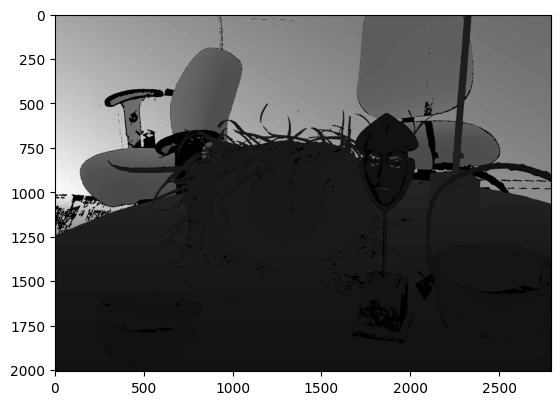

In [36]:
depth_standard = read_depth()

# 显示标准深度图像
depth_disparity2 = cv2.normalize(depth_standard, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
plt.imshow(depth_disparity2, cmap='gray')
plt.show()

## 点云生成网格